In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os




In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 #the loss calculated properly
EPOCHS = 20
BS = 32



In [ ]:
DIRECTORY = #dataset directory
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)#this step is necessary if we are going to deal with MobileNet

    	data.append(image)
    	labels.append(category)#we have to convert the text labels to array--> label binarizer method --> convert label variables into 
			#categorical variables

# convert the data and labels to NumPy arrays
#data = np.array(data, dtype="float32")
#labels = np.array(labels)

[INFO] loading images...


In [ ]:
# perform one-hot encoding on the labels: to obtain numerical variables(0 and 1)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)#Converts a class vector (integers) to binary class matrix.

#convert variables to numpy arrays because only with arrays our DL model will work
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)#random_state is to always obtain same results 

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off

##mobilenet are faster than cnns in order of process(they use lesser parameters) but it's less accurate
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 32s 334ms/step - loss: 0.3692 - accuracy: 0.8352 - val_loss: 0.1147 - val_accuracy: 0.9648
Epoch 2/20
95/95 [==============================] - 30s 317ms/step - loss: 0.1121 - accuracy: 0.9585 - val_loss: 0.0721 - val_accuracy: 0.9739
Epoch 3/20
95/95 [==============================] - 30s 317ms/step - loss: 0.0863 - accuracy: 0.9707 - val_loss: 0.0538 - val_accuracy: 0.9831
Epoch 4/20
95/95 [==============================] - 30s 318ms/step - loss: 0.0634 - accuracy: 0.9799 - val_loss: 0.0453 - val_accuracy: 0.9857
Epoch 5/20
95/95 [==============================] - 30s 319ms/step - loss: 0.0537 - accuracy: 0.9829 - val_loss: 0.0426 - val_accuracy: 0.9870
Epoch 6/20
95/95 [==============================] - 30s 320ms/step - loss: 0.0473 - accuracy: 0.9852 - val_loss: 0.0382 - val_accuracy: 0.9883
Epoch 7/20
95/95 [==============================] - 30s 318ms/step - loss: 0.0467 - accuracy

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


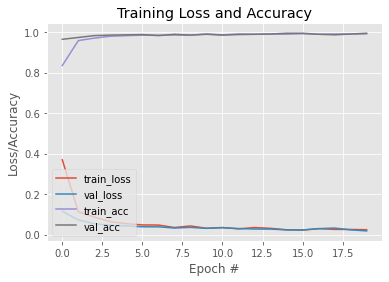

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")